##### import library

##### import library

In [1]:
import sys
sys.path.append("../..")
sys.path.append("../../..")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, cohen_kappa_score
import seaborn as sns
import kaos 
import utility


##### Read data

In [3]:
df_Gain_calculated = pd.read_excel("../../../data/MetaData_ecoli_final.xlsx", sheet_name= "Gain score")
df_Gain_calculated.head()

,Position,Gene,Allele,Ref_allele,Alt_allele,Annotation,label,accumulated_gain
0,63,intergenic,A->C,A,C,noncoding,p6,-10.385914
1,201,thrL,T->G,T,G,missense,p6,-1.750693
2,241,thrL,A->C,A,C,missense,m1,-0.911836
3,309,thrA,T->G,T,G,noncoding,m1,4.009052
4,322,thrA,A->G,A,G,noncoding,p3,1.532477


In [4]:
df_Gain_calculated["key"] = df_Gain_calculated["label"] + "_" +  df_Gain_calculated["Gene"] + "_" + df_Gain_calculated["Position"].astype(str)  + "_" + df_Gain_calculated["Ref_allele"]  + "_" + df_Gain_calculated["Alt_allele"]

In [5]:
df_Alt_allele_count_all_generation = pd.read_excel("../../../data/MetaData_ecoli_final.xlsx", sheet_name= "Mastersheet")
# df_Alt_allele_count_all_generation.head()
df_Alt_allele_count_all_generation.drop_duplicates(subset=['CHROM','Position', 'Gene', 'Allele', 'Annotation', 'Ref_allele', 'Alt_allele','label'], inplace=True)
df_Alt_allele_count_all_generation.reset_index(inplace=True, drop=True)
df_complete = pd.merge(df_Gain_calculated,df_Alt_allele_count_all_generation, on=['Position','Gene','Allele','Annotation','Ref_allele','Alt_allele','label'], how = "left")

filtered_list = [item for item in df_complete if item.startswith("AC")] ## Fiter the column starting with "AC" which indicate allele count
filtered_list.extend(['CHROM','Position', 'Gene', 'Allele', 'Annotation', 'Ref_allele', 'Alt_allele','label', "accumulated_gain"]) ##Add other relavent information
df_allele_generation = df_complete[filtered_list]
df_allele_generation.head() 


,AC:0,AC:1000,AC:1500,AC:2000,AC:2500,AC:3000,AC:4000,AC:4500,AC:5000,AC:5500,...,AC:60000,CHROM,Position,Gene,Allele,Annotation,Ref_allele,Alt_allele,label,accumulated_gain
0,0,0,0,0,0.0,0,0,0,0,0,...,6.0,chrI,63,intergenic,A->C,noncoding,A,C,p6,-10.385914
1,0,0,0,0,0.0,0,0,0,0,0,...,13.0,chrI,201,thrL,T->G,missense,T,G,p6,-1.750693
2,0,0,0,0,0.0,0,0,0,0,0,...,0.0,chrI,241,thrL,A->C,missense,A,C,m1,-0.911836
3,0,0,0,0,0.0,0,0,0,0,0,...,9.0,chrI,309,thrA,T->G,noncoding,T,G,m1,4.009052
4,0,0,0,0,0.0,0,0,0,0,0,...,0.0,chrI,322,thrA,A->G,noncoding,A,G,p3,1.532477


In [6]:
mutator_list = ['m1', 'm2', 'm3', 'm4', 'p3', 'p6']
non_mutator_list = ['p1', 'p2', 'p4', 'p5', 'm5', 'm6']

In [7]:
nan_columns = df_allele_generation.columns[df_allele_generation.isna().any()]
df_with_nan = df_allele_generation[nan_columns]
nan_counts = df_allele_generation.isna().sum()
nan_counts = nan_counts[nan_counts > 0]
print("\n Number of NaN values in each column:")
print(nan_counts)


 Number of NaN values in each column:
AC:2500      355
AC:15000    4953
AC:46500     331
AC:58000    3753
AC:58500     355
AC:59000     355
AC:59500     355
AC:60000     355
dtype: int64


In [8]:
df_allele_generation.drop(nan_counts.index.tolist(), axis = 1, inplace=True)
df_allele_generation.reset_index(inplace=True, drop = True)
df_allele_generation.head()

/tmp/ipykernel_1205094/435986532.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_allele_generation.drop(nan_counts.index.tolist(), axis = 1, inplace=True)


,AC:0,AC:1000,AC:1500,AC:2000,AC:3000,AC:4000,AC:4500,AC:5000,AC:5500,AC:6000,...,AC:57500,CHROM,Position,Gene,Allele,Annotation,Ref_allele,Alt_allele,label,accumulated_gain
0,0,0,0,0,0,0,0,0,0,0,...,36,chrI,63,intergenic,A->C,noncoding,A,C,p6,-10.385914
1,0,0,0,0,0,0,0,0,0,0,...,79,chrI,201,thrL,T->G,missense,T,G,p6,-1.750693
2,0,0,0,0,0,0,0,0,0,0,...,0,chrI,241,thrL,A->C,missense,A,C,m1,-0.911836
3,0,0,0,0,0,0,0,0,0,0,...,0,chrI,309,thrA,T->G,noncoding,T,G,m1,4.009052
4,0,0,0,0,0,0,0,0,0,0,...,26,chrI,322,thrA,A->G,noncoding,A,G,p3,1.532477


In [9]:
df_allele_generation["key"] = df_allele_generation["label"] + "_" +  df_allele_generation["Gene"] + "_" + df_allele_generation["Position"].astype(str)  + "_" + df_allele_generation["Ref_allele"]  + "_" + df_allele_generation["Alt_allele"]

/tmp/ipykernel_1205094/3034850833.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_allele_generation["key"] = df_allele_generation["label"] + "_" +  df_allele_generation["Gene"] + "_" + df_allele_generation["Position"].astype(str)  + "_" + df_allele_generation["Ref_allele"]  + "_" + df_allele_generation["Alt_allele"]


In [10]:
df_Gain_calculated = pd.merge(df_Gain_calculated, df_allele_generation, on = ["key", "Gene", "Allele", "Ref_allele", "Alt_allele", "label", "Annotation", "Position", "accumulated_gain"])

In [11]:
df_Gain_calculated

,Position,Gene,Allele,Ref_allele,Alt_allele,Annotation,label,accumulated_gain,key,AC:0,...,AC:53500,AC:54000,AC:54500,AC:55000,AC:55500,AC:56000,AC:56500,AC:57000,AC:57500,CHROM
0,63,intergenic,A->C,A,C,noncoding,p6,-10.385914,p6_ intergenic_63_ A_C,0,...,34,44,71,38,49,78,45,22,36,chrI
1,201,thrL,T->G,T,G,missense,p6,-1.750693,p6_ thrL_201_ T_G,0,...,40,78,76,70,100,140,93,28,79,chrI
2,241,thrL,A->C,A,C,missense,m1,-0.911836,m1_ thrL_241_ A_C,0,...,18,22,15,6,6,1,2,0,0,chrI
3,309,thrA,T->G,T,G,noncoding,m1,4.009052,m1_ thrA_309_ T_G,0,...,0,0,0,0,0,0,0,0,0,chrI
4,322,thrA,A->G,A,G,noncoding,p3,1.532477,p3_ thrA_322_ A_G,0,...,30,14,14,10,23,24,13,16,26,chrI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36917,4629541,lasT,C->T,C,T,missense,m2,-4.635292,m2_ lasT_4629541_ C_T,0,...,0,0,0,0,0,0,0,0,0,chrI
36918,4629573,lasT,T->C,T,C,synonymous,m4,-7.657991,m4_ lasT_4629573_ T_C,0,...,0,0,0,0,0,0,0,0,0,chrI
36919,4629600,lasT,A->G,A,G,missense,p3,2.403010,p3_ lasT_4629600_ A_G,0,...,45,37,24,13,33,47,32,33,35,chrI
36920,4629600,lasT,A->G,A,G,missense,p6,2.403010,p6_ lasT_4629600_ A_G,0,...,0,1,0,0,0,1,0,0,0,chrI


##### Read population wise data and concat in single dataframe

In [12]:
m1_population = pd.read_excel("../../../data/m1_annotated_timecourse.xlsx","Sheet2") 
m1_population["label"] = "m1" 
m1_population = m1_population[['Position','Gene','Allele','Annotation','Test.statistic','P-value','Ref_allele','Alt_allele','ref_flanking_regions','alt_flanking_regions','label']]

m2_population = pd.read_excel("../../../data/m2_annotated_timecourse.xlsx","Sheet2") 
m2_population["label"] = "m2" 
m2_population = m2_population[['Position','Gene','Allele','Annotation','Test.statistic','P-value','Ref_allele','Alt_allele','ref_flanking_regions','alt_flanking_regions','label']]

m3_population = pd.read_excel("../../../data/m3_annotated_timecourse.xlsx","Sheet2") 
m3_population["label"] = "m3" 
m3_population = m3_population[['Position','Gene','Allele','Annotation','Test.statistic','P-value','Ref_allele','Alt_allele','ref_flanking_regions','alt_flanking_regions','label']]

m4_population = pd.read_excel("../../../data/m4_annotated_timecourse.xlsx","Sheet2") 
m4_population["label"] = "m4" 
m4_population = m4_population[['Position','Gene','Allele','Annotation','Test.statistic','P-value','Ref_allele','Alt_allele','ref_flanking_regions','alt_flanking_regions','label']]

m5_population = pd.read_excel("../../../data/m5_annotated_timecourse.xlsx","Sheet2") 
m5_population["label"] = "m5" 
m5_population = m5_population[['Position','Gene','Allele','Annotation','Test.statistic','P-value','Ref_allele','Alt_allele','ref_flanking_regions','alt_flanking_regions','label']]

m6_population = pd.read_excel("../../../data/m6_annotated_timecourse.xlsx","Sheet2") 
m6_population["label"] = "m6" 
m6_population = m6_population[['Position','Gene','Allele','Annotation','Test.statistic','P-value','Ref_allele','Alt_allele','ref_flanking_regions','alt_flanking_regions','label']]

p1_population = pd.read_excel("../../../data/p1_annotated_timecourse.xlsx","Sheet2") 
p1_population["label"] = "p1" 
p1_population = p1_population[['Position','Gene','Allele','Annotation','Test.statistic','P-value','Ref_allele','Alt_allele','ref_flanking_regions','alt_flanking_regions','label']]

p2_population = pd.read_excel("../../../data/p2_annotated_timecourse.xlsx","Sheet2") 
p2_population["label"] = "p2" 
p2_population = p2_population[['Position','Gene','Allele','Annotation','Test.statistic','P-value','Ref_allele','Alt_allele','ref_flanking_regions','alt_flanking_regions','label']]

p3_population = pd.read_excel("../../../data/p3_annotated_timecourse.xlsx","Sheet2") 
p3_population["label"] = "p3" 
p3_population = p3_population[['Position','Gene','Allele','Annotation','Test.statistic','P-value','Ref_allele','Alt_allele','ref_flanking_regions','alt_flanking_regions','label']]

p4_population = pd.read_excel("../../../data/p4_annotated_timecourse.xlsx","Sheet2") 
p4_population["label"] = "p4" 
p4_population = p4_population[['Position','Gene','Allele','Annotation','Test.statistic','P-value','Ref_allele','Alt_allele','ref_flanking_regions','alt_flanking_regions','label']]

p5_population = pd.read_excel("../../../data/p5_annotated_timecourse.xlsx","Sheet2") 
p5_population["label"] = "p5" 
p5_population = p5_population[['Position','Gene','Allele','Annotation','Test.statistic','P-value','Ref_allele','Alt_allele','ref_flanking_regions','alt_flanking_regions','label']]


p6_population = pd.read_excel("../../../data/p6_annotated_timecourse.xlsx","Sheet2") 
p6_population["label"] = "p6" 
p6_population = p6_population[['Position','Gene','Allele','Annotation','Test.statistic','P-value','Ref_allele','Alt_allele','ref_flanking_regions','alt_flanking_regions','label']]


df = pd.concat([m1_population,m2_population,m3_population,m4_population,m5_population,m6_population,p1_population,p2_population,p3_population,p4_population,p5_population,p6_population])

In [13]:
df[df.duplicated(subset=['Position', 'Gene', 'Allele', 'Annotation', 'Test.statistic', 'P-value',
       'Ref_allele', 'Alt_allele', 'ref_flanking_regions',
       'alt_flanking_regions', 'label'])]

df["key"] = df["label"] + "_" +  df["Gene"] + "_" + df["Position"].astype(str)  + "_" + df["Ref_allele"]  + "_" + df["Alt_allele"]
df.reset_index(inplace=True, drop=True)

In [14]:
df.head()

,Position,Gene,Allele,Annotation,Test.statistic,P-value,Ref_allele,Alt_allele,ref_flanking_regions,alt_flanking_regions,label,key
0,241,thrL,A->C,missense,2.887050,0.000100,A,C,TACCACAGGTAACGGTGCGGG,TACCACAGGTCACGGTGCGGG,m1,m1_ thrL_241_ A_C
1,309,thrA,T->G,noncoding,4.732560,0.000300,T,G,GGCTTTTTTTTCGACCAAAGG,GGCTTTTTTTGCGACCAAAGG,m1,m1_ thrA_309_ T_G
2,1615,thrA,T->G,missense,0.986369,0.000100,T,G,AATATCAACATTGTCGCCATT,AATATCAACAGTGTCGCCATT,m1,m1_ thrA_1615_ T_G
3,6046,yaaA,C->A,missense,1.681940,0.077982,C,A,TTCCCTCGGGCATTCTCAAGA,TTCCCTCGGGAATTCTCAAGA,m1,m1_ yaaA_6046_ C_A
4,6220,yaaA,T->G,missense,2.478710,0.000100,T,G,AACGCCAGAATCGCCTGGCGG,AACGCCAGAAGCGCCTGGCGG,m1,m1_ yaaA_6220_ T_G


##### Make a dictionary with reference flank and alternate flank (21 base pair) with kmer length 1, 2 , 3

In [15]:
dct = dict()


for i in range(df.shape[0]):

    # print(i)

    key = df.loc[i, "key"]

    dct[key] = dict()

    ref_flank = df.loc[i, "ref_flanking_regions"]
    alt_flank = df.loc[i, "alt_flanking_regions"]

    # print(ref_flank, alt_flank)

    dct[key]["ref"] = dict()
    dct[key]["alt"] = dict()

    dct[key]["ref"][1] = kaos.chaos_frequency_matrix(ref_flank, kmer_length=1, pseudo_count=False)[0].ravel().tolist()
    dct[key]["ref"][2] = kaos.chaos_frequency_matrix(ref_flank, kmer_length=2, pseudo_count=False)[0].ravel().tolist()
    dct[key]["ref"][3] = kaos.chaos_frequency_matrix(ref_flank, kmer_length=3, pseudo_count=False)[0].ravel().tolist()
    dct[key]["alt"][1] = kaos.chaos_frequency_matrix(alt_flank, kmer_length=1, pseudo_count=False)[0].ravel().tolist()
    dct[key]["alt"][2] = kaos.chaos_frequency_matrix(alt_flank, kmer_length=2, pseudo_count=False)[0].ravel().tolist()
    dct[key]["alt"][3] = kaos.chaos_frequency_matrix(alt_flank, kmer_length=3, pseudo_count=False)[0].ravel().tolist()


In [16]:
def return_X_all_ref_alt(kmer_length, target_col):

    X = list()
    y = list()

    tmp_col = list()

    for k in kmer_length:

        col_ref = [element + '_ref' for element in kaos.chaos_frequency_matrix("AGTC", kmer_length=k, pseudo_count=False)[1].ravel()]
        col_alt = [element + '_alt' for element in kaos.chaos_frequency_matrix("AGTC", kmer_length=k, pseudo_count=False)[1].ravel()]
        tmp_col = tmp_col + col_ref + col_alt

    for i in range(df_Gain_calculated["key"].shape[0]):

        key = df_Gain_calculated.loc[i, "key"]

        tmp = list()

        for k in kmer_length:

            X_ref = dct[key]['ref'][k]
            X_alt = dct[key]['alt'][k]

            tmp = tmp + X_ref + X_alt

        X.append(tmp)

        tmp = None
        
        if target_col=="accumulated_gain":
            y.append(df_Gain_calculated.loc[i, "accumulated_gain"])

    X = pd.DataFrame(X, columns= tmp_col)

    return X, y

In [17]:
def linear_regression(X, y):
    
    """
    Perform Linear Regression using statsmodels and evaluate model performance.

    Parameters:
        X (DataFrame): Feature matrix
        y (Series): Target variable (continuous)

    Returns:
        summary_df (DataFrame): Coefficients, p-values, and confidence intervals
        metrics (dict): Model evaluation metrics (R², RMSE)
    """

    # Add constant (intercept term)
    X = sm.add_constant(X)

    # Split dataset into train-test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Fit the Linear Regression model
    model = sm.OLS(y_train, X_train).fit()

    print(model.summary())

    # Get p-values, coefficients, and confidence intervals
    summary_df = pd.DataFrame({
        "Coefficient": model.params,
        "p-value": model.pvalues,
    })

    # Predictions on test set
    y_pred = model.predict(X_test)

    # Compute evaluation metrics
    metrics = {
        "R² Score": r2_score(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred))
    }

    return summary_df, metrics, y_pred, y_test


In [18]:
X, y = return_X_all_ref_alt(kmer_length = [1, 2, 3], target_col= "accumulated_gain")
coeff_df, metrics, y_pred, y_test = linear_regression(X, y)
# print(metrics)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.488
Model:                            OLS   Adj. R-squared:                  0.486
Method:                 Least Squares   F-statistic:                     222.4
Date:                Sat, 22 Feb 2025   Prob (F-statistic):               0.00
Time:                        21:51:52   Log-Likelihood:                -80910.
No. Observations:               29537   AIC:                         1.621e+05
Df Residuals:                   29410   BIC:                         1.631e+05
Df Model:                         126                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0111      0.000    -88.729      0.0

In [19]:
coeff_df.head()

,Coefficient,p-value
const,-0.011108,0.000000
C_ref,-0.020989,0.463055
G_ref,-0.056193,0.045991
A_ref,-0.118490,0.000023
T_ref,-0.037594,0.178992


##### Predicted kGain vs actual kGain reference and alternate \n using Mono, Di, tri nucleotide

In [20]:
# fig, ax = plt.subplots(1, 1, dpi=300, figsize=(2, 2))
# pearson_correlation = np.corrcoef(y_pred, y_test)[0][1]
# # Create scatter plot
# sns.scatterplot(x=y_test, y=y_pred, ax=ax, s=1, c = "blue")
# ax.set_xlabel("Actual kGain score")
# ax.set_ylabel("Predicted kGain score")
# ax.set_title("Predicted kGain vs actual kGain reference and alternate \n using Mono, Di, tri nucleotide", fontsize = 5)
# stats_text = f"R2: {metrics['R² Score']:.3e} | RMSE: {metrics['RMSE']:.3e} | Pearson correlation: {pearson_correlation:.3e}"
# ax.text(
#     0.5, 0.95, stats_text, 
#     transform=ax.transAxes, fontsize=4, verticalalignment='top', horizontalalignment='center',
#     bbox=dict(boxstyle="round,pad=0.1", edgecolor="None", facecolor="white")
# )
# ax = utility.custom_figure_axis(ax=ax, fontsize = 6, rotation = 0)
# # plt.savefig("Predicted kGain vs actual.pdf", dpi = 600)
# # plt.savefig("Predicted kGain vs actual.png", dpi = 300)


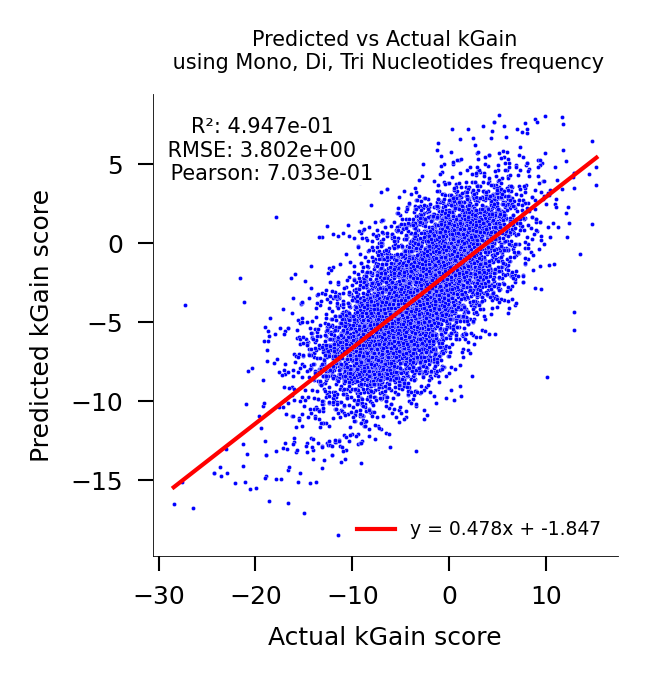

In [21]:
y_test = np.array(y_test)
y_pred = np.array(y_pred)


X = sm.add_constant(y_test)  
model = sm.OLS(y_pred, X).fit() 

# Extract Slope (m), Intercept (b), and MSE
intercept, slope = model.params  # b, m
y_fit = intercept + slope * y_test  # Regression line
mse = mean_squared_error(y_test, y_pred)

pearson_correlation = np.corrcoef(y_pred, y_test)[0][1]

fig, ax = plt.subplots(1, 1, dpi=300, figsize=(2, 2))
ax = sns.scatterplot(x=y_test, y=y_pred, ax=ax, s=1, color="blue")

ax = sns.lineplot(x=y_test, y=y_fit, ax=ax, color="red", linewidth=1, label=f"y = {slope:.3f}x + {intercept:.3f}")

ax.set_xlabel("Actual kGain score")
ax.set_ylabel("Predicted kGain score")
ax.set_title("Predicted vs Actual kGain\n using Mono, Di, Tri Nucleotides frequency", fontsize=5)

stats_text = (f"R²: {model.rsquared:.3e}  \n RMSE: {np.sqrt(mse):.3e}  "
              f" \n Pearson: {pearson_correlation:.3e}")
ax.text(
    0.25, 0.95, stats_text, transform=ax.transAxes, fontsize=5,
    verticalalignment='top', horizontalalignment='center',
    bbox=dict(boxstyle="round,pad=0.1", edgecolor="None", facecolor="white")
)


ax.legend(ncol = 1, fontsize = 4.5, frameon=False)
ax = utility.custom_figure_axis(ax=ax, fontsize=6, rotation=0)
plt.savefig("regression OLS nucelo.pdf", dpi=300)
plt.savefig("regression OLS nucelo.png", dpi=300)


#####  Coefficient of mono, di, tri nucleotide kmer in reference and alternate flank (21 base pairs)

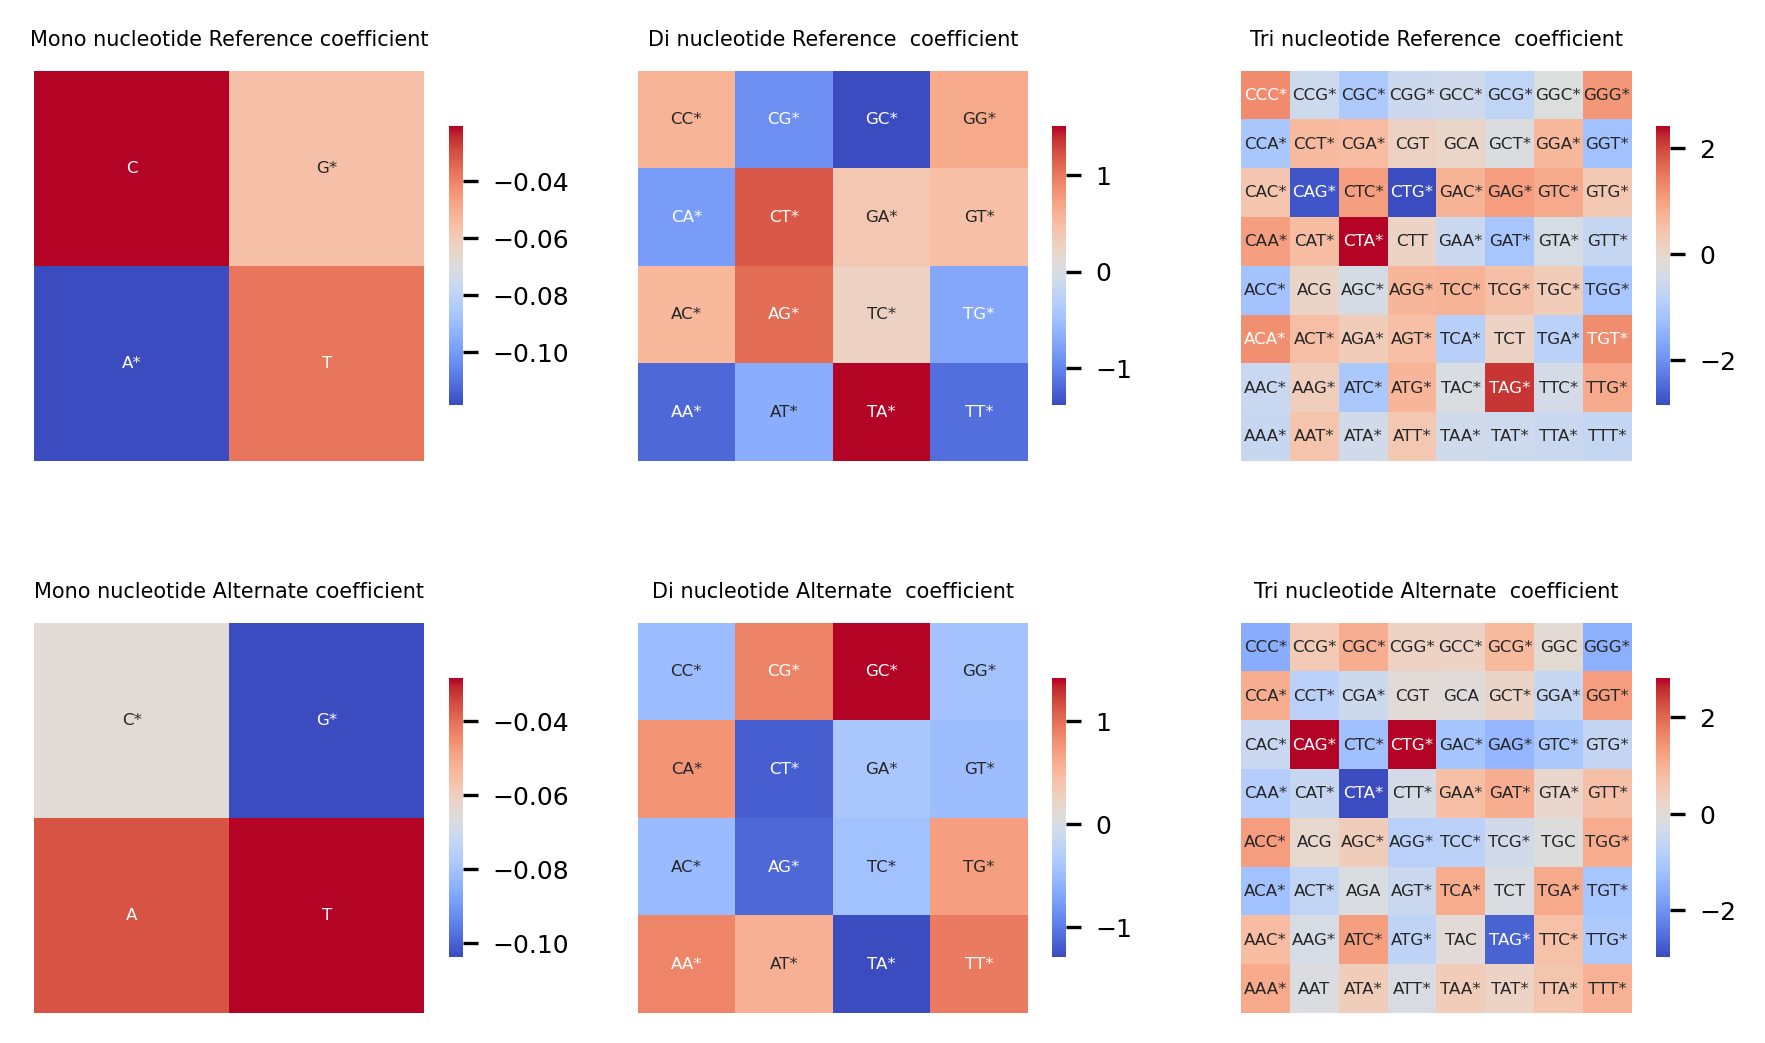

In [22]:
fig, ax = plt.subplots(2, 3, dpi = 300, figsize = (6, 4))

for kmer_length in [1, 2, 3]:

    result_key = np.array(list(kaos.chaos_game_representation_key(kmer_length=kmer_length).ravel()))
    result_kmer_ref = [item + "_ref" for item in list(kaos.chaos_game_representation_key(kmer_length=kmer_length).ravel())]
    result_kmer_alt = [item + "_alt" for item in list(kaos.chaos_game_representation_key(kmer_length=kmer_length).ravel())]

    # print(result_key)
    result_ref = pd.merge(coeff_df.reset_index(), pd.DataFrame(result_kmer_ref, columns = ["index"]))
    result_alt = pd.merge(coeff_df.reset_index(), pd.DataFrame(result_kmer_alt, columns = ["index"]))

    # p_kmer_ref = 

    p_kmer_ref = np.array(result_ref["p-value"]).reshape(-1, 2**kmer_length)
    p_kmer_alt = np.array(result_alt["p-value"]).reshape(-1, 2**kmer_length)

    result_key = result_key.reshape(-1, 2**kmer_length)


# import numpy as np

    # Ensure it's a NumPy array of object type
    result_key_ref = np.array(list(kaos.chaos_game_representation_key(kmer_length=kmer_length).ravel())).reshape(-1, 2**kmer_length)
    result_key_alt =  np.array(list(kaos.chaos_game_representation_key(kmer_length=kmer_length).ravel())).reshape(-1, 2**kmer_length)

    # Ensure it's an object array so that string concatenation works
    result_key_ref = result_key_ref.astype(object)
    result_key_alt = result_key_alt.astype(object)

    for i in range(2**kmer_length):
        for j in range(2**kmer_length):

            if p_kmer_ref[i, j] <= 0.05:
                result_key_ref[i, j] = str(result_key_ref[i, j]) + "*"

            if p_kmer_alt[i, j] <= 0.05:
                result_key_alt[i, j] = str(result_key_alt[i, j]) + "*"
    
    ax[0][kmer_length-1] = sns.heatmap(np.array(result_ref["Coefficient"]).reshape(-1, 2**kmer_length), 
                annot=np.array(result_key_ref),  # Ensure shape matches
                fmt="",  # Allow string annotations
                annot_kws={"size": 4},
                cbar_kws={"shrink": 0.5},
                square=True,
                cmap="coolwarm", ax = ax[0][kmer_length-1])
    
    ax[1][kmer_length-1] = sns.heatmap(np.array(result_alt["Coefficient"]).reshape(-1, 2**kmer_length), 
            annot=np.array(result_key_alt),
            fmt="",  
            annot_kws={"size": 4},
            cbar_kws={"shrink": 0.5},
            square=True,
            cmap="coolwarm", ax = ax[1][kmer_length-1])

ax[0][0].set_title("Mono nucleotide Reference coefficient", fontsize = 5)
ax[1][0].set_title("Mono nucleotide Alternate coefficient", fontsize = 5)
ax[0][1].set_title("Di nucleotide Reference  coefficient", fontsize = 5)
ax[1][1].set_title("Di nucleotide Alternate  coefficient", fontsize = 5)
ax[0][2].set_title("Tri nucleotide Reference  coefficient", fontsize = 5)
ax[1][2].set_title("Tri nucleotide Alternate  coefficient", fontsize = 5)

for i in range(2):
    for j in range(3):
        ax[i][j].set_xticklabels([])
        ax[i][j].set_xticks([])
        ax[i][j].set_yticklabels([])
        ax[i][j].set_yticks([])
        # Adjust font size of colorbar text
        cbar = ax[i][j].collections[0].colorbar
        cbar.ax.tick_params(labelsize=6)  # Decrease font size


plt.tight_layout()

# plt.savefig("coefficient.pdf", dpi = 600)

# plt.savefig("coefficient.png", dpi = 300)